# 논문 리뷰 및 프로토 타이핑  
### "Face-Spoofing 2D-Detection Based on Moire-Pattern Analysis"
Colab 환경에서 작성  
### 논문 링크
[IEEE Xplore](https://ieeexplore.ieee.org/abstract/document/7056504)  
[PDF](https://fga.unb.br/articles/0000/8149/Moire_face_spoofing_detection.pdf)

# 사전 준비

## 논문 주제
face spoofing detection을 위해 fourier transform으로 spoof image에서 나타나는 moire 패턴을 감지/수치화하여  
face spoofing을 탐지하는 프로세스를 정의합니다.  
___

## about face spoofing
spoof는 한글로 속이다를 뜻하며 face spoofing은 얼굴 속이기.. 정도라고 할 수 있습니다.  
Face ID로 잠겨있는 누군가의 아이폰을 그 사람의 얼굴에 대지 않고 얼굴이 찍힌 사진에 대고 잠금 해제하려는 시도로 생각하면 됩니다. (물론 Face ID는 이렇게 쉽게 뚤리지 않습니다. 이미지 기반이 아니기 때문)  
얼굴 사진을 구하는 일은 어렵지 않기 때문에 이러한 시도는 얼굴 인식은 물론 카메라를 사용한 생체 인식 기반 보안기술에 큰 위협이 됩니다.  
<br>
이 논문은 이러한 시도를 막기 위해 spoofing을 탐지하는 프로세스를 제시합니다.
___

## 샘플 이미지 다운로드

In [1]:
# original image
!gdown https://drive.google.com/uc?id=1eMIe35oQBNNYNr16JI6v5Hphdqi-tgRC

# spoof image
!gdown https://drive.google.com/uc?id=1At7TaX12GL5D6o6QCPa6BAnPGbWMEeac

Downloading...
From: https://drive.google.com/uc?id=1eMIe35oQBNNYNr16JI6v5Hphdqi-tgRC
To: /content/sample_original.jpeg
100% 30.2k/30.2k [00:00<00:00, 64.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1At7TaX12GL5D6o6QCPa6BAnPGbWMEeac
To: /content/sample_spoof.jpeg
100% 2.77M/2.77M [00:00<00:00, 138MB/s]


___

## 라이브러리 임포트 +

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import Tuple

In [3]:
# visualize function
def genPlot(img1, img2, figSize=(8,8), cmap=None):
  plt.figure(figsize=figSize)

  plt.subplot(121)
  plt.imshow(img1, cmap=cmap)
  plt.title('original image')
  plt.xticks([]), plt.yticks([])

  plt.subplot(122)
  plt.imshow(img2, cmap=cmap)
  plt.title('spoof image')
  plt.xticks([]), plt.yticks([])

  plt.show()

___

## 샘플 이미지 로드/시각화

스마트폰이 얼굴 인식 기술로 잠겨있는 상황을 생각하시면 이해가 편합니다.  
- original image는 1번 촬영된 사진으로 정상 통과해야합니다.
- spoof image는 2번 이상 촬영된 사진으로 이미 촬영된 이미지에 대고 얼굴 인식을 해제하려는 시도로 이를 탐지하고 막아야 합니다.

In [1]:
# read original
original_image = cv2.imread('/content/sample_original.jpeg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# read spoof
spoof_image = cv2.imread('/content/sample_spoof.jpeg')
spoof_image = cv2.cvtColor(spoof_image, cv2.COLOR_BGR2RGB)

print(f'original image shape: {original_image.shape}')
print(f'   spoof image shape: {spoof_image.shape}')

# visualize
genPlot(original_image, spoof_image)

NameError: name 'cv2' is not defined

- original image는 인터넷에서 구한 사진을 캡쳐
- spoof image는 캡쳐한 사진을 모니터에 띄운 뒤 스마트폰으로 재촬영한 사진

---

## 샘플 이미지 푸리에 변환/시각화

In [5]:
# define fourier transform funcion
def fourier_transforms(img):
  if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)

  spectrum = np.log(np.abs(fshift))
  spectrum = cv2.normalize(spectrum, None, 0, 255, cv2.NORM_MINMAX)
  spectrum = spectrum.astype(int)

  return spectrum

- 논문에서는 가짜 사진에서는 촬영 기기의 디지털 그리드와 디스플레이의 픽셀 그리드 간 중첩(overlap)으로 촬영 이미지에 특정한 구조(artifacts)가 나타난다고 주장합니다.
"모아레 패턴"으로 잘 알려져 있습니다.

- 원본 사진에서도 격자와 같은 무늬를 확인 가능하지만 주파수로 변환해보면 더 쉽고 명확한 패턴으로 나타납니다.

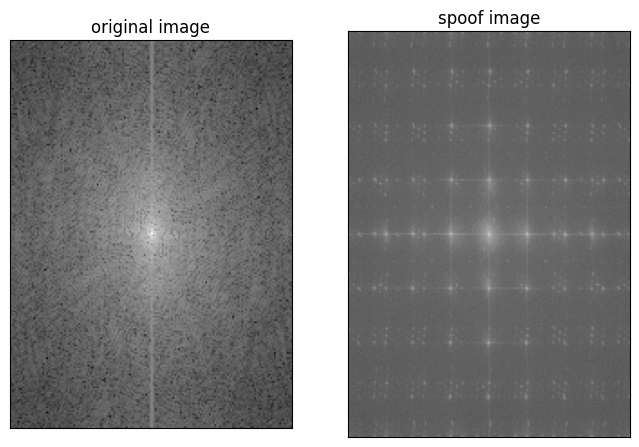

In [6]:
# fourier transform for both image
original_transformed = fourier_transforms(original_image)
spoof_transformed = fourier_transforms(spoof_image)

# visualize
genPlot(original_transformed, spoof_transformed, cmap='gray')

- original image의 경우 저주파 영역이 나타나는 중앙 밖에선 peak가 나타나지 않습니다.
- 하지만, spoof image의 경우 중앙 밖 고주파 영역 부분에 많은 peak를 관찰할 수 있습니다.
- 논문에서는 이러한 peak들을 통해 정의한 값(p-value)을 통해 spoof image를 탐지합니다.
---

# 프로세스 정의

## 개요
논문에선 앞서 관찰한 peak들을 p-value로 수치화하기 위한 알고리즘을 제안합니다.  
수치화 이후 적절한 p_min을 설정해  
- p-value가 p_min보다 큰 경우 real image,  
- p보다 작은 경우 fake image로 분류하는 모델을 제시하고 있습니다.  

정의된 알고리즘을 실험 환경에서 더 나아가 보편적인 상황에 성공적으로 분류할 수 있도록  
DoG* 필터의 값을 바꿔가며 여러번 반복 할 수 있습니다. (아래 참고)  
<img src = "https://drive.google.com/uc?id=1OPwS4AYGWMfaTTJDofT1aN8_DsvZ6Vi1">

## 프로세스 순서

1. DoG 필터링
2. 푸리에 변환
3. 이미지 스레숄딩 및 p 값 추출
4. 분류

---

## 프로세스 상세 설명 및 구현

### 1. DoG 필터링
DoG Difference of Gaussian의 줄임말로 말 그대로 가우시안의 차 입니다.

DoG function:
$D(\sigma,k)=G(0,\sigma^2)-G(0,k\sigma^2)$

(G : gaussian distribution function)

두 개의 가우시안 분포의 차이를 나타내는 함수입니다.  
라플라시안 필터와 함께 엣지 검출에 종종 사용되는 필터입니다.

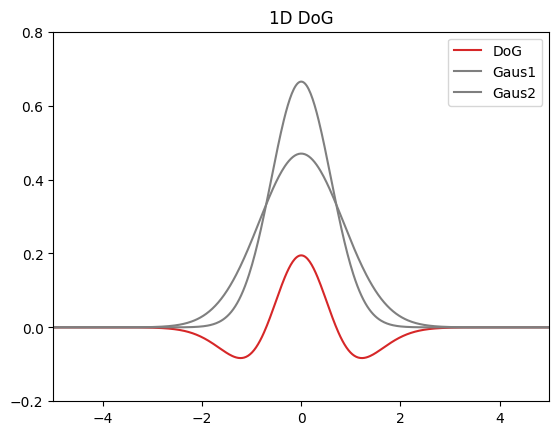

In [7]:
def dog_filter_1d(sigma, k):
  x = np.linspace(-10, 10, num=1000)

  mu = 0
  sigma2 = np.sqrt(k) * sigma

  g1 = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
  g2 = np.exp(-(x - mu)**2 / (2 * sigma2**2)) / (sigma2 * np.sqrt(2 * np.pi))

  DoG = g1 - g2

  fft = np.fft.fft(DoG) / len(DoG)
  fft_magnitude = abs(fft)

  plt.xlim(-5, 5)
  plt.ylim(-0.2, 0.8)

  plt.plot(x, DoG, label='DoG', color='#d62728')
  plt.plot(x, g1, label='Gaus1', color='#7f7f7f')
  plt.plot(x, g2, label='Gaus2', color='#7f7f7f')

  plt.title('1D DoG')
  plt.legend()

  plt.show()

dog_filter_1d(0.6, 2)

- 1D DoG 필터의 그래프를 보고 알 수 있듯 주변의 값을 음의 가중치로 반영 합니다.  
- 이는 값이 급격히 변하는 지점에서의 변화량을 더 크게 합니다.
- 논문에서는 검출 시 특정 고주파대를 강조하기 위해 사용합니다

샘풀 이미지에 DoG필터를 적용해보겠습니다.

In [8]:
def dog_filtering(img, k, sigma):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  sigma1 = sigma
  sigma2 = sigma * np.sqrt(k)

  blur1 = cv2.GaussianBlur(img, (5, 5), sigma1)
  blur2 = cv2.GaussianBlur(img, (5, 5), sigma2)

  dog = blur1 - blur2

  return dog

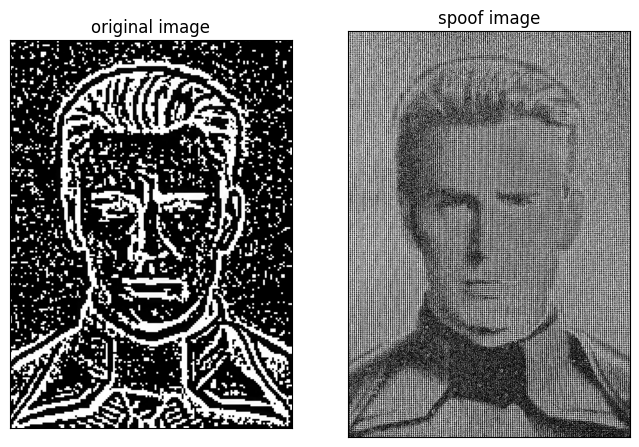

In [9]:
k = 2
sigma = 0.9

original_dog = dog_filtering(original_image, k=k, sigma=sigma)
spoof_dog = dog_filtering(spoof_image, k=k, sigma=sigma)

genPlot(original_dog, spoof_dog, cmap='gray')

---

### 2. 푸리에 변환
DoG 필터를 통해 특정 고주파대가 강조된 사진에 푸리에 변환을 수행합니다.

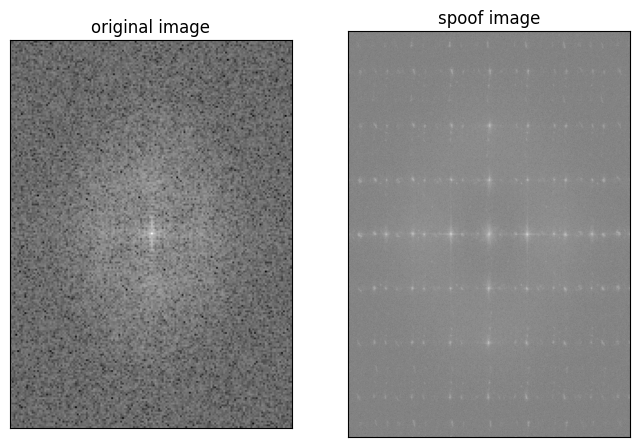

In [10]:
original_dog_dft = fourier_transforms(original_dog)
spoof_dog_dft = fourier_transforms(spoof_dog)

genPlot(original_dog_dft, spoof_dog_dft, cmap='gray')

---

### 3. pixelwise binary thresholding and extract p-value
DoG 필터가 적용된 이미지에 푸리에 변환을 수행한 뒤 pixelwise binary thresholding을 수행하는데 이 절차가 조금 복잡합니다.  
1. 우선 스레숄딩을 위한 최적의 임계값(threshold)를 설정합니다.
 - 원본 이미지 A와 스레숄드 처리된 이미지 B의 상관관계를 최대로 만드는 임계값을 최적의 임계값으로 정의합니다.
 - 이를 위해 픽셀의 최소~최대값(정수) 사이 모든 값에 대해 한번씩 임계값으로 설정하여 상관관계 수치화 작업를 반복(_get_t_value 함수)합니다.
 - 논문에서는 상관계수와 거의 유사한 방식의 수치화를 제안하며 해당 계산은 _get_coef 함수 내에 구현되어 있습니다.  
 <img src = "https://drive.google.com/uc?id=1h-j3zW4ITjWZU330-RhNUVCxURC2t-GI"><br>
2. 1에서 구한 최적 임계값으로 바이너리 스레숄딩 처리 후 p-value를 추출합니다.
 - p-value는 다음 식을 통해 추출됩니다.  
 <img src = "https://drive.google.com/uc?id=1zdA_1zT1FfC2CtxShRppgmkgAwlDq1ny"><br>
 - 픽셀 값의 단순 합을 전체 픽셀로 나누는 아주 간단한 식입니다.
 - 바이너리 스레숄딩 후 픽셀은 0과 1값만 갖기 때문에 픽셀에서 1이 등장하는 확률 값과 같습니다.

In [11]:
def pixelwise_threshding(dog_filtered_img):
  ERROR_CORRECTION = 2**4
  best_coef, best_threshold = _get_t_value(dog_filtered_img)

  result = np.where(dog_filtered_img <= best_threshold + ERROR_CORRECTION, 0, 1)

  p_value = np.sum(result) / (result.shape[0] * result.shape[1])

  return result, p_value

def _get_coef(threshold, prob_g, std_of_a, mean_of_a):
  LEFT_prob_sum, RIGHT_prob_sum = 0, 0
  LEFT_probxg_sum, RIGHT_probxg_sum = 0, 0

  for g, prob in prob_g.items():
    if g <= threshold:
        LEFT_prob_sum += prob
        LEFT_probxg_sum += prob * g

    else:
        RIGHT_prob_sum += prob
        RIGHT_probxg_sum += prob * g

  mu0 = LEFT_probxg_sum / LEFT_prob_sum
  mu1 = RIGHT_probxg_sum / RIGHT_prob_sum

  EB = (mu0 * LEFT_prob_sum) + (mu1 * RIGHT_prob_sum)
  EBB = ((mu0 ** 2) * LEFT_prob_sum) + ((mu1 ** 2) * RIGHT_prob_sum)
  EAB = (mu0 * LEFT_probxg_sum) + (mu1 * RIGHT_probxg_sum)

  EA = mean_of_a

  coef_numerator = EAB - (EA * EB)
  coef_denominator = std_of_a * np.sqrt(EBB - (EB ** 2))

  coef = coef_numerator / coef_denominator

  return coef


def _get_t_value(input_):
  num_of_pixel = input_.shape[0] * input_.shape[1]
  area_floor, area_ceil = np.min(input_), np.max(input_)

  std_of_a = np.std(input_)  # np.sqrt(EAA - (EA ** 2))
  mean_of_a = np.mean(input_)  # EA

  unique, counts = np.unique(input_, return_counts=True)
  prob_g = dict(zip(unique, counts / num_of_pixel))

  best_threshold, best_coef = 0, 0

  # for threshold in np.linspace(area_floor, area_ceil, num=50):
  for threshold in range(area_floor, area_ceil):

    # get_coef for each threshold
    try:
        coef = _get_coef(threshold=threshold,
                          prob_g=prob_g,
                          std_of_a=std_of_a,
                          mean_of_a=mean_of_a)

        if best_coef < coef:
            best_coef = coef
            best_threshold = threshold
        # print(f'threshold={threshold}, coef={coef}')

    except ZeroDivisionError:
        print(f'zero division except: {threshold}')
        pass

  return best_coef, best_threshold

앞서 2번 과정에서 이후 나온 결과물에 스레숄딩을 수행해보겠습니다.  
<br>
최적의 threshold를 구하는 과정에서 문제가 있는지 너무 낮은 threshold가 뽑혀 이상한 결과가 나와서 threshold를 임의로 증가시켰습니다.  
pixelwise_threshding 함수의 첫 줄 ERROR_CORRECTION = 2**4 부분 입니다.

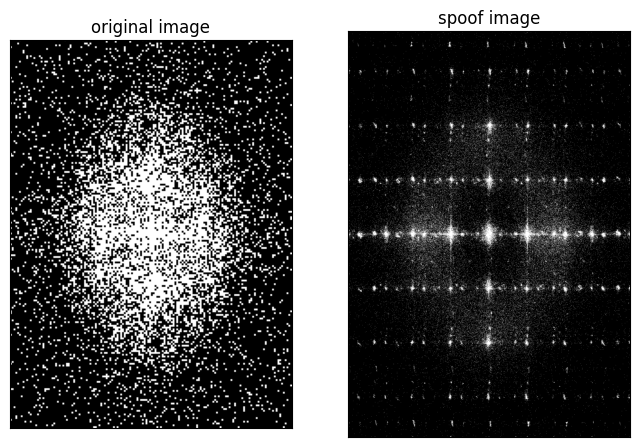

p-value of original image = 0.2454
p-value of spoof image    = 0.0623


In [12]:
original_threholded, original_p_value = pixelwise_threshding(original_dog_dft)
spoof_threholded, spoof_p_value = pixelwise_threshding(spoof_dog_dft)

genPlot(original_threholded, spoof_threholded, cmap='gray')
print(f'p-value of original image = {original_p_value:.4f}')
print(f'p-value of spoof image    = {spoof_p_value:.4f}')

___

### 4. 분류
분류는 단순합니다.임의로 p_min을 설정하고 추출된 p-value와 비교합니다.
- p-value >= p_min : real image
- p-value < p_min : fake image  

논문에서 p-value는 이미지에 peak가 나타날 때, 즉 spoof image일 때 아주 작은 값으로 나타난다고 합니다.
<br>  
계산 식을 통해 추측해보건데 높은 픽셀 값을 가지는 peak가 존재하는 경우 최적 threshold를 구하는 과정에서 peak 값들에 영향을 받아 비교적 높은 threshold가 설정되고 이에 픽셀 대부분이 0으로 설정되어 낮은 p-value로 나타나는 것이라 생각합니다.

In [23]:
def isSpoof(p, p_min=0.1):
  p_min = p_min

  if p >= p_min:
    return False  # Negative ~ Real Image

  else:
    return True  # Positive ~ Spoof Image

In [24]:
original_image_prediction = 'Spoof' if isSpoof(original_p_value) else 'Real'
spoof_image_prediction = 'Spoof' if isSpoof(spoof_p_value) else 'Real'

print(f'original image prediction: {original_image_prediction}')
print(f'spoof image prediction: {spoof_image_prediction}')

original image prediction: Real
spoof image prediction: Spoof


___

# 마무리

## 의견
- 제시된 프로세스를 구현 외에도 상당히 손이 많이 가는 분류 모델이라 생각합니다. 그 이유로
 1. p_min의 적정 범위나 이를 찾기 위한 왕도가 없습니다.  
   - 적용하고 싶은 도메인의 데이터셋을 대상으로 p-value 를 추출해 작성한 통계에 기반해 p_min을 설정하는 것 말고는 마땅한 방법이 생각나지 않습니다.
 2. 입력 이미지에 따라 p-value의 변동이 너무 큽니다.
   - 이미지의 사이즈(w*h)에 따라 p-value의 변화 폭이 매우 컸습니다.
   - 모션 블러, 밝기 등 다양한 변수에 큰 영향을 받는 fourier transform에 기반하였기 때문에 이미지 품질에 따라 값이 크게 변화합니다.  
<br>
- 정리해보면 입력 이미지의 입력 상황/품질이 보장되는 도메인이 아니면 robust한 성능을 내기 힘들어 도입에 적합하지 않는 기법이라 생각합니다.  
<br>
- 또한 1번 내용과 같이 규모 있는 데이터셋을 통한 통계에 기반해 임계값 (p_min)을 설정해야 하는데 이렇게 사용가능한 데이터셋이 있다면 ML/DL모델을 활용해 학습하는 방식이 더 안정적이고 좋은 성능을 낼 수 있을것입니다.  
<br>
- 연산 속도 관점에서도 기술이 탑재될 엣지 디바이스에 따라 차이가 있겠지만 스마트폰에도 고성능 gpu가 장착되어 나오는 요즘 상황에서 이를 활용하지 못하고 cpu연산만 가능한 fourier transform, cv 기반의 이런 모델을 사용하는 이점이 없다고 판단됩니다.

---

## end to end function

In [27]:
def classificationSpoof(img:np.ndarray, p_min:float=0.01) -> Tuple[str, float]:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = dog_filtering(img, k=2, sigma=0.9)
    img = fourier_transforms(img)
    threholded, p_value = pixelwise_threshding(img)

    label = 'Spoof' if isSpoof(p_value, p_min) else 'Real'

    return label, p_value

In [28]:
image:np.ndarray = cv2.imread('/content/sample_spoof.jpeg')
prediction, p = classificationSpoof(image)

print(f'prediction: {prediction}')
print(f'p-value: {p}')

prediction: Real
p-value: 0.06227793579107109


___